In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


In [2]:

# Load the dataset
df_cpi = pd.read_csv('T10YIE.CSV')

In [3]:
# Load the dataset
df = pd.read_csv('Production_Dataset.CSV')

In [4]:

# Rename the column to 'Inflation_Rate'
df_cpi.rename(columns={'T10YIE': 'Inflation_Rate'}, inplace=True)

In [5]:
df.head()
# Handle NaNs in df_cpi by backfilling and forward filling
df_cpi['Inflation_Rate'].fillna(method='bfill', inplace=True)
df_cpi['Inflation_Rate'].fillna(method='ffill', inplace=True)

# Convert the Date column in df to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Convert the observation_date column in df_cpi to datetime format
df_cpi['observation_date'] = pd.to_datetime(df_cpi['observation_date'])

# Merge the Inflation_Rate column from df_cpi to df based on the Date column
df = df.merge(df_cpi[['observation_date', 'Inflation_Rate']], left_on='Date', right_on='observation_date', how='left')

# Drop the redundant observation_date column
df.drop(columns=['observation_date'], inplace=True)

# Handle any remaining NaNs in the merged dataframe
df['Inflation_Rate'].fillna(method='bfill', inplace=True)
df['Inflation_Rate'].fillna(method='ffill', inplace=True)

# Display the first few rows of the updated dataframe
df.head()

/var/folders/nq/cfcdv3jd4l953lwjh_p6n6cm0000gn/T/ipykernel_32004/3877017318.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cpi['Inflation_Rate'].fillna(method='bfill', inplace=True)
/var/folders/nq/cfcdv3jd4l953lwjh_p6n6cm0000gn/T/ipykernel_32004/3877017318.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cpi['Inflation_Rate'].fillna(method='ffill', inplace=True)
/var/folders/nq/cfcdv3jd4l953lwjh_p6n6cm0000gn/T/ipykernel_32004/3877017318.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Inflation_Rate'].fillna(method='bfill', inplace=True)
/var/folders/nq/cfcdv3jd4l953lwjh_p6n6cm0000gn/T/ipykernel_32004/3877017318.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future

,Production_Hours,Workforce_Size,Machine_Efficiency,Raw_Materials_Cost,Maintenance_Hours,Shift_Hours,Total_Production,Production Type,Production Line,Supplier,...,Timestamp_Hour,Department,Equipment_Age_Category,Shift_Category,Project_Complexity,Quality_Risk_Level,Energy_Efficiency_Level,Production_Flexibility,Supply_Chain_Resilience,Inflation_Rate
0,-0.90,-0.01,-0.50,-0.41,-0.40,-0.57,-4.31,Industrial Equipment,Line D,EuroTrade Supplies,...,22,Maintenance,Old,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.37
1,-1.20,-1.13,-1.72,-1.64,-1.46,-1.66,-8.42,Electronics,Line A,GlobalTech Components,...,8,Maintenance,Old,Low,Simple,Low,Low_Consumption,Rigid,Low,2.25
2,-0.40,-0.92,-0.81,0.02,0.42,0.32,-2.79,Electronics,Line A,Quantum Resource Group,...,11,Logistics,Old,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.26
3,0.15,0.59,1.40,0.73,1.32,0.87,3.20,Electronics,Line A,NorthStar Manufacturing,...,15,Logistics,New,High,Moderate,High,High_Consumption,Moderate,Medium,2.26
4,0.68,0.60,0.05,0.46,0.70,0.56,2.11,Precision Components,Line E,Advanced Materials Inc.,...,3,Quality_Control,Medium,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.35


In [6]:
# look where inflation rate column is null
df.head()

,Production_Hours,Workforce_Size,Machine_Efficiency,Raw_Materials_Cost,Maintenance_Hours,Shift_Hours,Total_Production,Production Type,Production Line,Supplier,...,Timestamp_Hour,Department,Equipment_Age_Category,Shift_Category,Project_Complexity,Quality_Risk_Level,Energy_Efficiency_Level,Production_Flexibility,Supply_Chain_Resilience,Inflation_Rate
0,-0.90,-0.01,-0.50,-0.41,-0.40,-0.57,-4.31,Industrial Equipment,Line D,EuroTrade Supplies,...,22,Maintenance,Old,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.37
1,-1.20,-1.13,-1.72,-1.64,-1.46,-1.66,-8.42,Electronics,Line A,GlobalTech Components,...,8,Maintenance,Old,Low,Simple,Low,Low_Consumption,Rigid,Low,2.25
2,-0.40,-0.92,-0.81,0.02,0.42,0.32,-2.79,Electronics,Line A,Quantum Resource Group,...,11,Logistics,Old,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.26
3,0.15,0.59,1.40,0.73,1.32,0.87,3.20,Electronics,Line A,NorthStar Manufacturing,...,15,Logistics,New,High,Moderate,High,High_Consumption,Moderate,Medium,2.26
4,0.68,0.60,0.05,0.46,0.70,0.56,2.11,Precision Components,Line E,Advanced Materials Inc.,...,3,Quality_Control,Medium,Medium,Moderate,Medium,Medium_Consumption,Moderate,Medium,2.35


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Production_Hours            1000 non-null   float64       
 1   Workforce_Size              1000 non-null   float64       
 2   Machine_Efficiency          1000 non-null   float64       
 3   Raw_Materials_Cost          1000 non-null   float64       
 4   Maintenance_Hours           1000 non-null   float64       
 5   Shift_Hours                 1000 non-null   float64       
 6   Total_Production            1000 non-null   float64       
 7   Production Type             1000 non-null   object        
 8   Production Line             1000 non-null   object        
 9   Supplier                    1000 non-null   object        
 10  Date                        1000 non-null   datetime64[ns]
 11  Production_Volume_Per_Hour  1000 non-null   float64      

## EDA

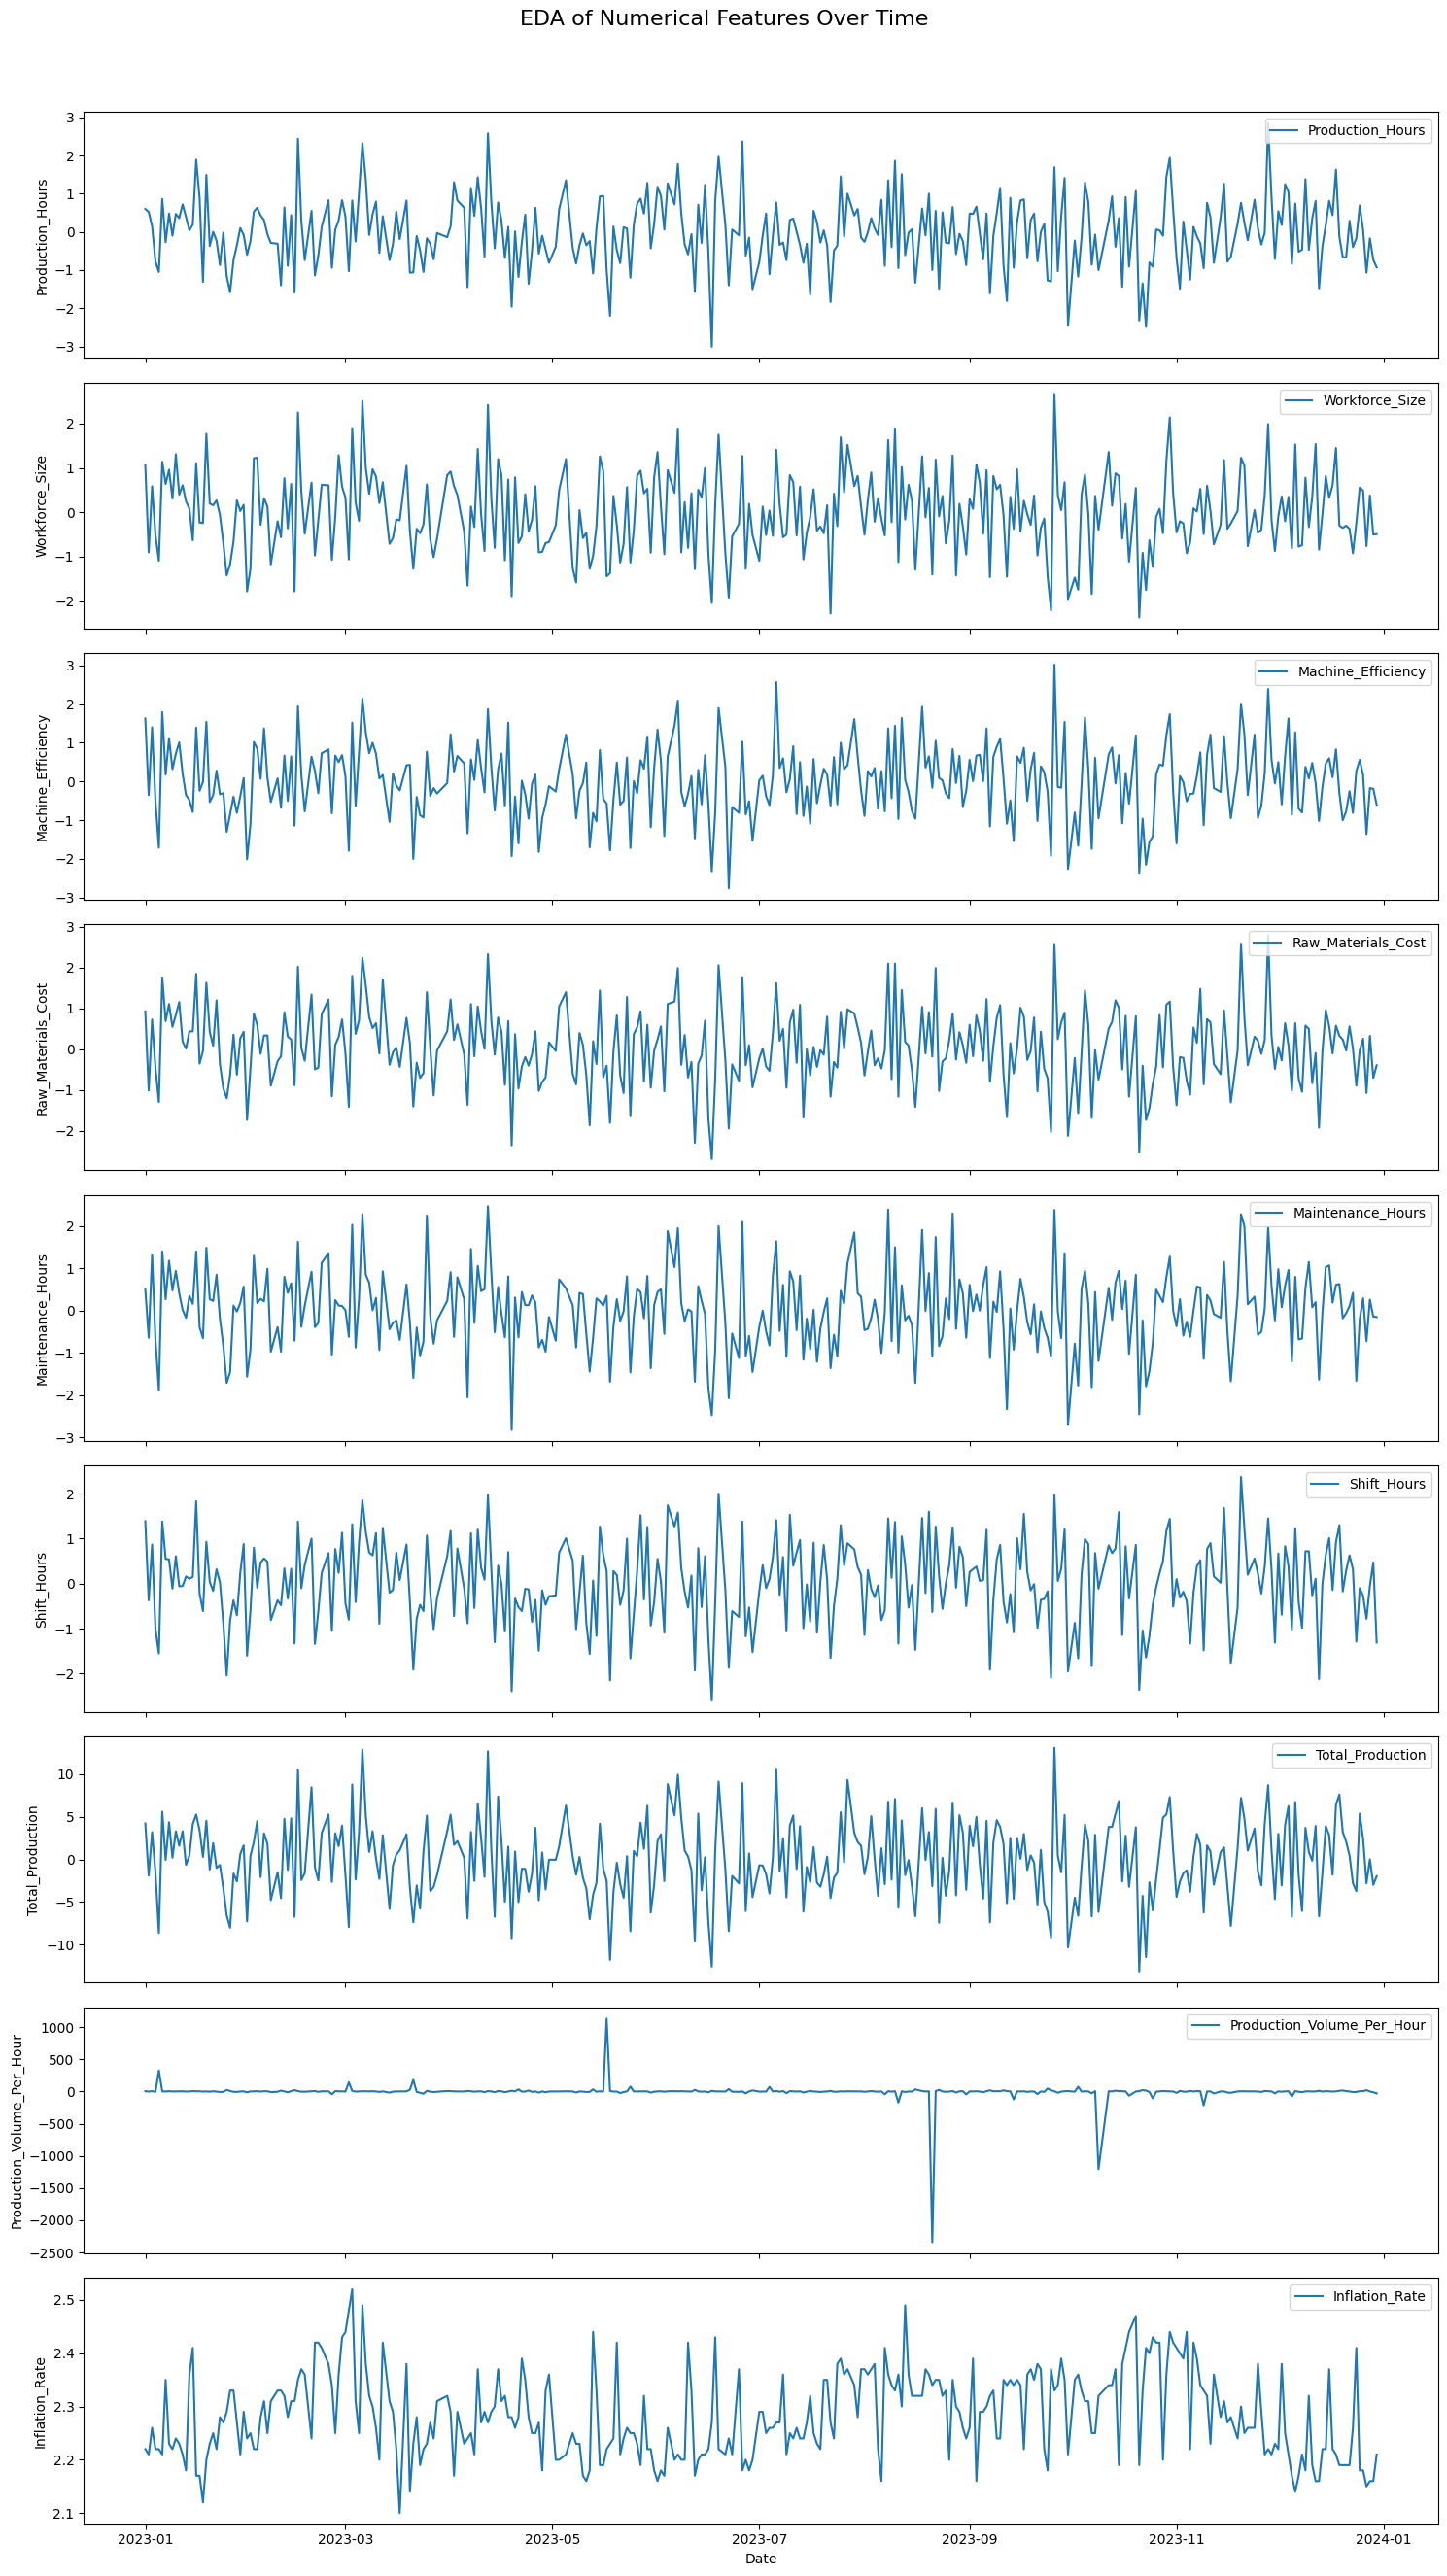

In [10]:
# List of numerical features to plot
numerical_features = ['Production_Hours', 'Workforce_Size', 'Machine_Efficiency', 'Raw_Materials_Cost', 
                      'Maintenance_Hours', 'Shift_Hours', 'Total_Production', 'Production_Volume_Per_Hour', 
                      'Inflation_Rate']

# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(15, 3 * len(numerical_features)), sharex=True)

# Plot each numerical feature over time
for i, feature in enumerate(numerical_features):
    axes[i].plot(df.index, df[feature], label=feature)
    axes[i].set_ylabel(feature)
    axes[i].legend(loc='upper right')

# Set the x-axis label
axes[-1].set_xlabel('Date')

# Set the title for the entire figure
fig.suptitle('EDA of Numerical Features Over Time', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()



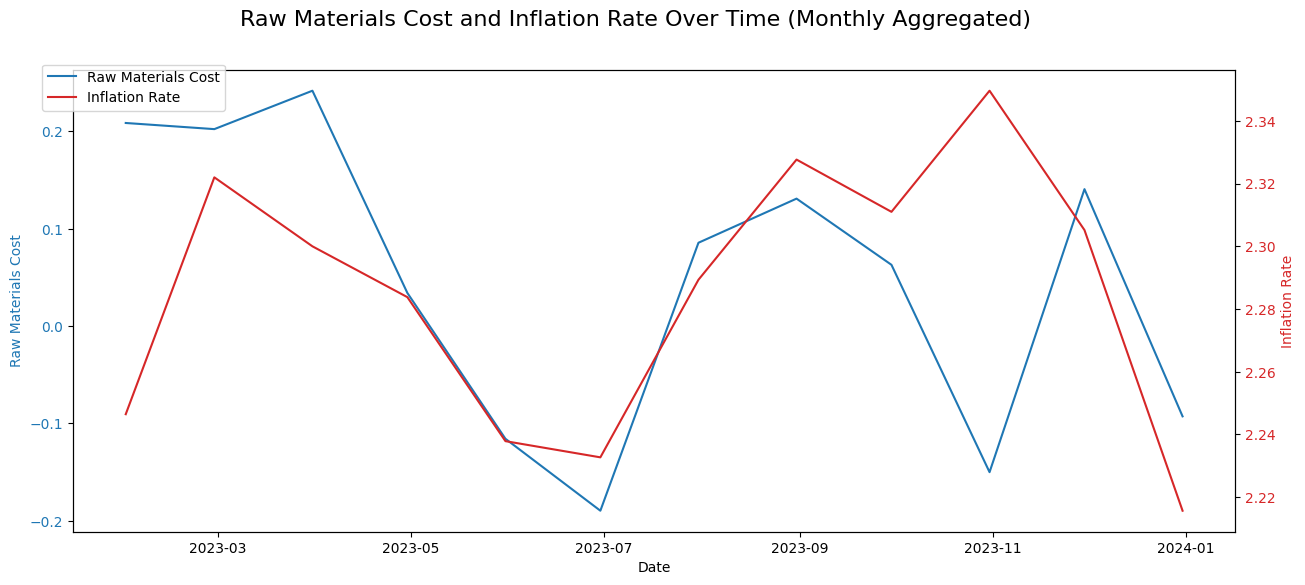

In [13]:
# Select only the numeric columns for resampling
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Resample the dataframe to monthly frequency, aggregating by mean
df_monthly = df[numeric_columns].resample('M').mean()

# Create a plot for Raw Materials Cost and Inflation Rate over time at a monthly level
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Raw Materials Cost
ax1.plot(df_monthly.index, df_monthly['Raw_Materials_Cost'], color='tab:blue', label='Raw Materials Cost')
ax1.set_xlabel('Date')
ax1.set_ylabel('Raw Materials Cost', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot Inflation Rate
ax2 = ax1.twinx()
ax2.plot(df_monthly.index, df_monthly['Inflation_Rate'], color='tab:red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and legend
fig.suptitle('Raw Materials Cost and Inflation Rate Over Time (Monthly Aggregated)', fontsize=16)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

## Model

15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing


NaNs in Inflation_Rate before processing: 0
NaNs in df_prophet before modeling: ds                0
y                 0
Inflation_Rate    0
dtype: int64
          ds     y  Inflation_Rate
0 2023-01-01  0.93            2.22
1 2023-01-02 -1.01            2.21
2 2023-01-03  0.73            2.26
3 2023-01-04 -0.46            2.22
4 2023-01-05 -1.29            2.22
Index(['ds', 'y', 'Inflation_Rate'], dtype='object')
NaNs in future before prediction: ds                0
Inflation_Rate    0
dtype: int64


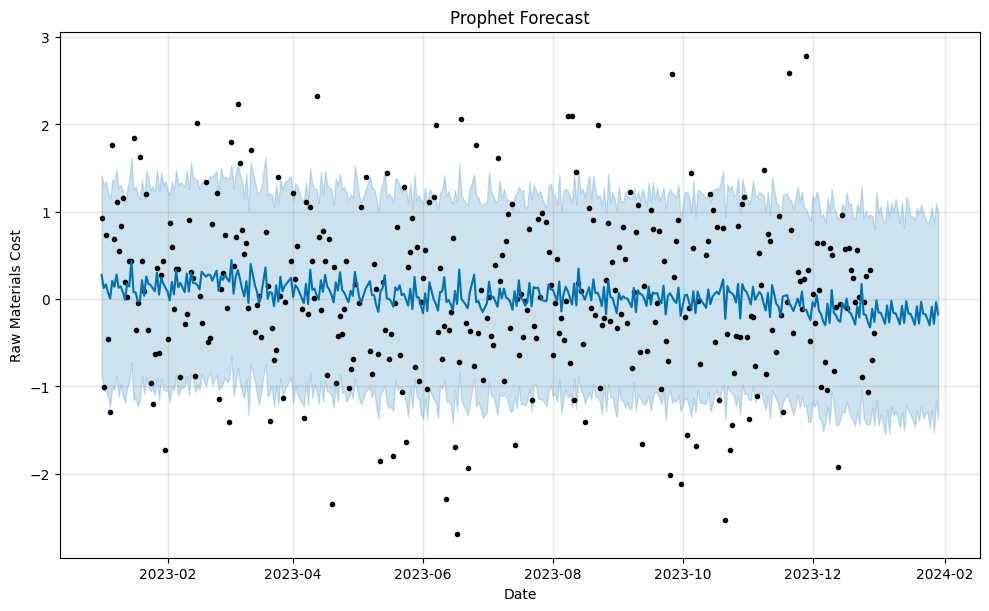

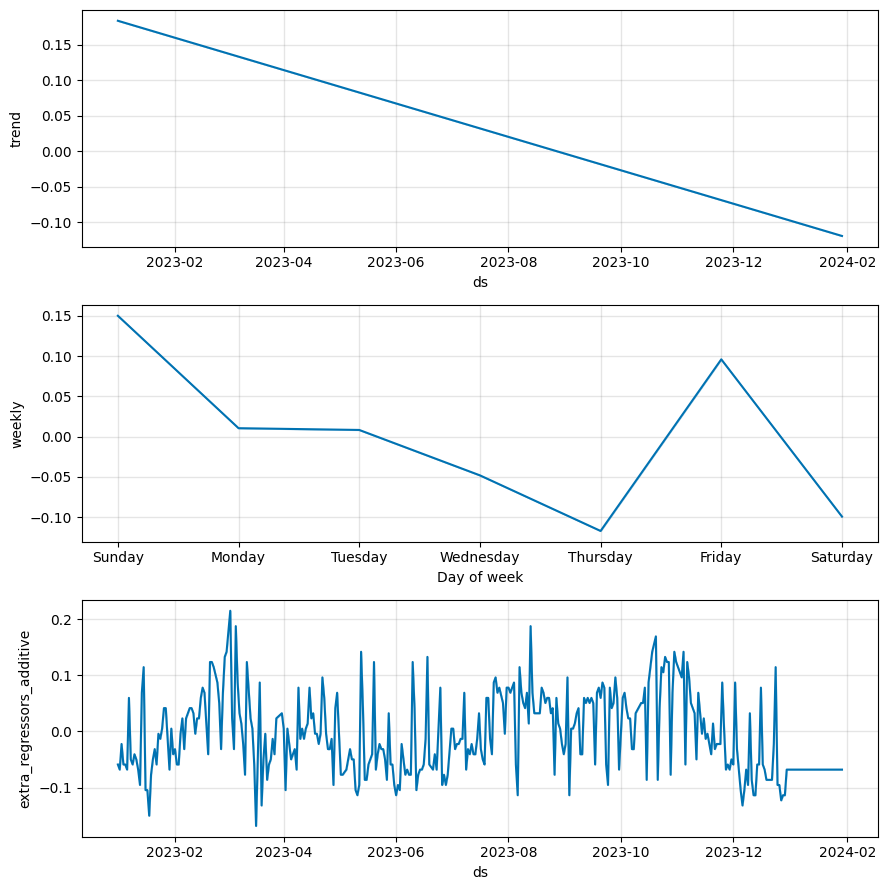

  0%|          | 0/9 [00:00<?, ?it/s]

15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:41 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1]

          ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-04-05 -0.045944   -1.124465    1.024711 -0.12 2023-04-04
1 2023-04-06 -0.297992   -1.269882    0.713742 -1.36 2023-04-04
2 2023-04-07  0.267842   -0.730229    1.269045  1.11 2023-04-04
3 2023-04-08  0.006244   -0.996661    1.017929 -0.17 2023-04-04
4 2023-04-09  0.733560   -0.333463    1.727661  1.05 2023-04-04
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'cutoff'], dtype='object')
df_cv is empty or does not contain the 'horizon' column.
   horizon       mse      rmse       mae     mdape     smape  coverage
0   3 days  0.821099  0.906145  0.688747  0.951999  1.497426  0.760000
1   4 days  0.997554  0.998776  0.756942  0.999145  1.560392  0.760000
2   5 days  0.919389  0.958848  0.738645  1.090207  1.588504  0.817778
3   6 days  0.917292  0.957754  0.752604  1.118216  1.627577  0.817778
4   7 days  0.659257  0.811946  0.636390  1.118216  1.563127  0.888889
5   8 days  1.291054  1.136246  0.894209  1.118216  

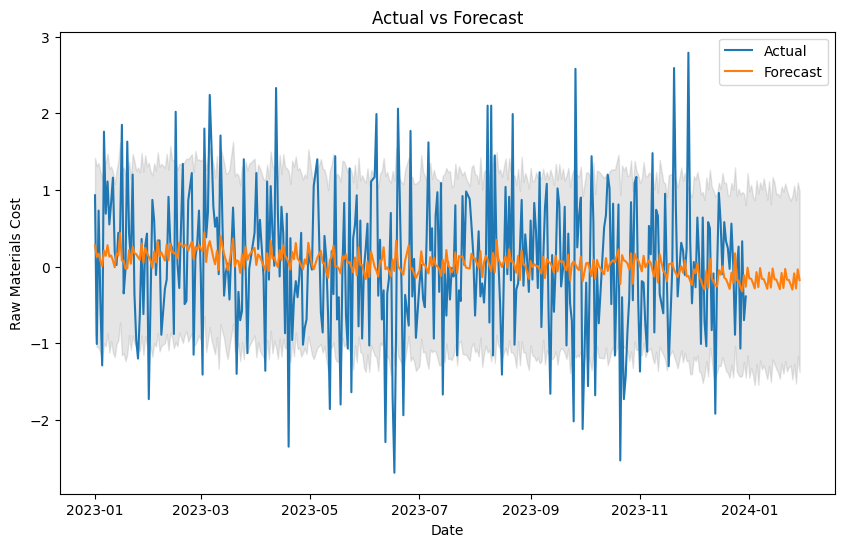

Length of y_true: 340
Length of y_pred: 340
MAE: 0.72
MAPE: 104757287625747.97%
RMSE: 0.92
R²: 0.02
Forecast Accuracy: -1047572876157.48%
NaNs in future_year before prediction: ds                0
Inflation_Rate    0
dtype: int64


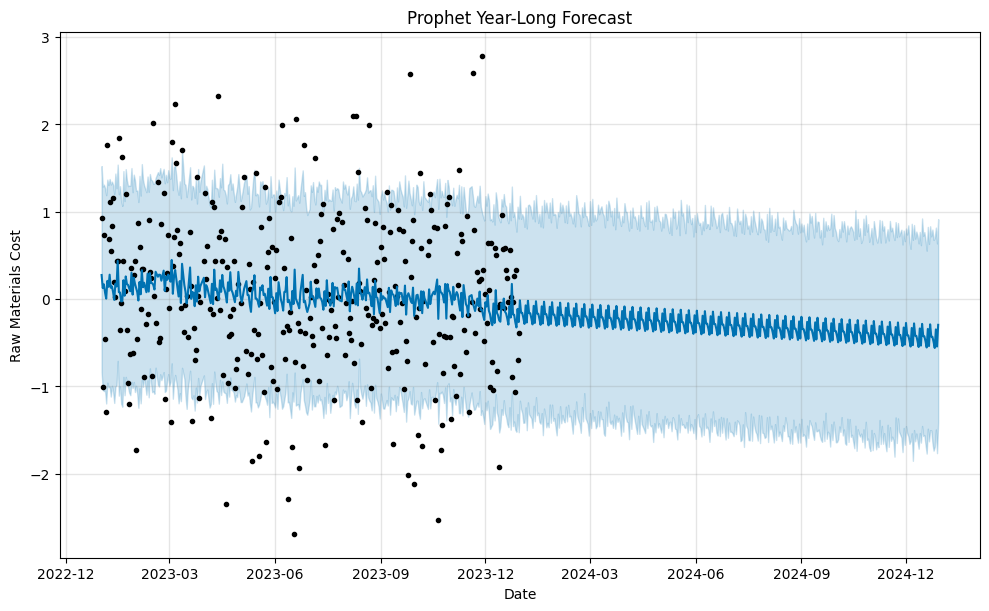

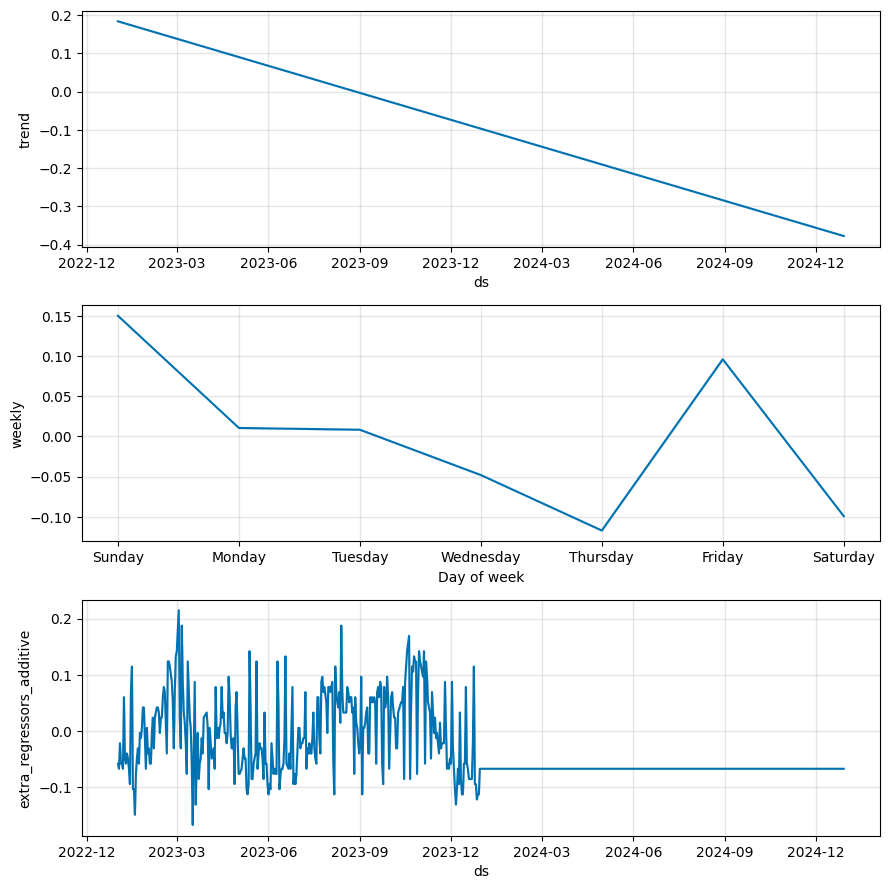

In [7]:


df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Ensure the index is unique
df = df[~df.index.duplicated(keep='first')]

# Check for NaNs in the Inflation_Rate column
print("NaNs in Inflation_Rate before processing:", df['Inflation_Rate'].isna().sum())

# Prepare the data for Prophet
df_prophet = df.reset_index()[['Date', 'Raw_Materials_Cost', 'Inflation_Rate']]
df_prophet.columns = ['ds', 'y', 'Inflation_Rate']

# Check for NaNs in df_prophet
print("NaNs in df_prophet before modeling:", df_prophet.isna().sum())

# Drop rows with NaNs in df_prophet
df_prophet = df_prophet.dropna()

# Debugging: Check the contents of df_prophet
print(df_prophet.head())
print(df_prophet.columns)

# Initialize and fit the Prophet model
model = Prophet() # (yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
model.add_regressor('Inflation_Rate')

model.fit(df_prophet)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=30)  # Predicting 1 month into the future
# Ensure the length of Inflation_Rate matches the length of future
if len(df['Inflation_Rate']) >= len(future):
    future['Inflation_Rate'] = df['Inflation_Rate'].iloc[-len(future):].values
else:
    future['Inflation_Rate'] = np.append(df['Inflation_Rate'].values, [df['Inflation_Rate'].values[-1]] * (len(future) - len(df['Inflation_Rate'])))

# Check for NaNs in future
print("NaNs in future before prediction:", future.isna().sum())

forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Raw Materials Cost')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Cross-validation
initial = '90 days'  # Initial training period (3 months)
period = '30 days'   # Spacing between cutoff dates (1 month)
horizon = '30 days'  # Forecast horizon (1 month)

# Perform cross-validation
df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

# Debugging: Check the contents of df_cv
print(df_cv.head())
print(df_cv.columns)

# Ensure df_cv is not empty and contains the necessary columns
if not df_cv.empty and 'horizon' in df_cv.columns:
    # Plot performance metrics
    fig3 = plot_cross_validation_metric(df_cv, metric='mape')
    plt.show()
else:
    print("df_cv is empty or does not contain the 'horizon' column.")

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Print performance metrics
print(df_p)

# Debugging: Check the contents of df_p
print(df_p.head())
print(df_p.columns)

# Visualize actuals vs forecast
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Raw Materials Cost')
plt.legend()
plt.show()

# Calculate additional performance metrics
# Align the forecast data with the actual data
forecast_aligned = forecast.set_index('ds').reindex(df_prophet['ds']).reset_index()
y_true = df_prophet['y']
y_pred = forecast_aligned['yhat']

# Debugging: Check the lengths of y_true and y_pred
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Ensure the lengths of y_true and y_pred are consistent
if len(y_true) == len(y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    accuracy = 100 - mape

    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2%}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R²: {r2:.2f}')
    print(f'Forecast Accuracy: {accuracy:.2f}%')
else:
    print("Inconsistent number of samples between y_true and y_pred.")

# Forecast a full year into the future
future_year = model.make_future_dataframe(periods=365)  # Predicting 1 year into the future

# Ensure the length of Inflation_Rate matches the length of future_year
if len(df['Inflation_Rate']) >= len(future_year):
    future_year['Inflation_Rate'] = df['Inflation_Rate'].iloc[-len(future_year):].values
else:
    future_year['Inflation_Rate'] = np.append(df['Inflation_Rate'].values, [df['Inflation_Rate'].values[-1]] * (len(future_year) - len(df['Inflation_Rate'])))

# Extend the Inflation_Rate data to match the future_year DataFrame
last_inflation_rate = df['Inflation_Rate'].iloc[-1]
future_year['Inflation_Rate'] = np.append(df['Inflation_Rate'].values, [last_inflation_rate] * (len(future_year) - len(df)))

# Check for NaNs in future_year
print("NaNs in future_year before prediction:", future_year.isna().sum())

forecast_year = model.predict(future_year)

# Plot the year-long forecast
fig4 = model.plot(forecast_year)
plt.title('Prophet Year-Long Forecast')
plt.xlabel('Date')
plt.ylabel('Raw Materials Cost')
plt.show()

# Plot the forecast components for the year-long forecast
fig5 = model.plot_components(forecast_year)
plt.show()

In [1]:
# export the notebook as a readable html file
!jupyter nbconvert --to html prophet_supplychain.ipynb

[NbConvertApp] Converting notebook prophet_supplychain.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1124123 bytes to prophet_supplychain.html


In [8]:

# Print statements for article content
print("\n--- Article Content ---")
print(f"Model Configuration: Yearly Seasonality: {model.yearly_seasonality}, Weekly Seasonality: {model.weekly_seasonality}, Daily Seasonality: {model.daily_seasonality}")
print(f"Exogenous Regressor: Inflation Rate")
print(f"Initial Training Period: {initial}")
print(f"Cross-Validation Period: {period}")
print(f"Forecast Horizon: {horizon}")
print(f"Performance Metrics:\nMAE: {mae:.2f}\nMAPE: {mape:.2%}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nForecast Accuracy: {accuracy:.2f}%")
print(f"Year-Long Forecast Summary:\n{forecast_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()}")


--- Article Content ---
Model Configuration: Yearly Seasonality: auto, Weekly Seasonality: auto, Daily Seasonality: auto
Exogenous Regressor: Inflation Rate
Initial Training Period: 90 days
Cross-Validation Period: 30 days
Forecast Horizon: 30 days
Performance Metrics:
MAE: 0.72
MAPE: 104757287625747.97%
RMSE: 0.92
R²: 0.02
Forecast Accuracy: -1047572876157.48%
Year-Long Forecast Summary:
            ds      yhat  yhat_lower  yhat_upper
700 2024-12-25 -0.490691   -1.737669    0.677363
701 2024-12-26 -0.560515   -1.694465    0.699001
702 2024-12-27 -0.348161   -1.494677    0.818148
703 2024-12-28 -0.544172   -1.765845    0.636790
704 2024-12-29 -0.295562   -1.415222    0.914943


## Forecasting Pipeline (WIP)